In [23]:
import os
from copy import deepcopy
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from game import *
from neuralNetwork import *
from agent import *
from main import * 

In [26]:
modelDirectory = "model/"
os.listdir(modelDirectory)

['.gitkeep', '.ipynb_checkpoints', '3789c7d4-02d0-11ed-8551-98fa9b20b553']

In [27]:
# retrieve models at every training steps, and run hyperparameters

run_id = "3789c7d4-02d0-11ed-8551-98fa9b20b553"
modelPath = modelDirectory + run_id + "/"

with open(modelPath + "lossDict.pickle", "rb") as f:
    lossDict = pickle.load(f)
    
with open(modelPath + "modelWeightsDict.pickle", "rb") as f:
    modelWeightsDict = pickle.load(f)
    
with open(modelPath + "hyperparameters.json", "r") as f:
    hyperparameters = json.load(f)

# Evolution of loss during training

Text(0, 0.5, 'Loss')

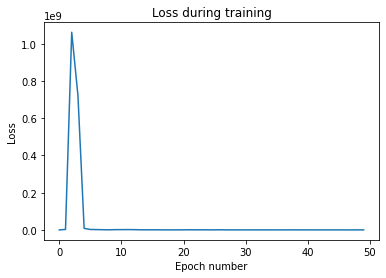

In [28]:
ax = plt.plot(lossDict.values())
plt.title("Loss during training")
plt.xlabel("Epoch number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

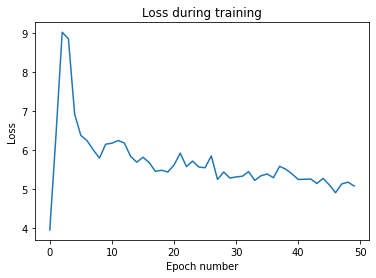

In [29]:
# same with log scale

val = [np.log10(el) for el in lossDict.values()]
ax = plt.plot(val)
plt.title("Loss during training")
plt.xlabel("Epoch number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

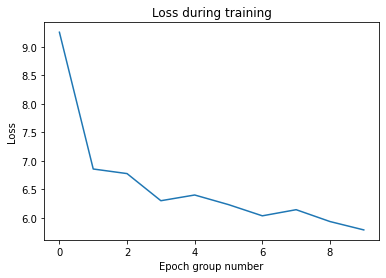

In [31]:
# log-average loss values, averaged over 5 epochs

val = np.array(list(lossDict.values()))
val = np.sum(val.reshape(-1, 5), axis=1) # average over 5 epochs
val = np.apply_along_axis(np.log10, 0, val) # take log
ax = plt.plot(val)
plt.title("Loss during training")
plt.xlabel("Epoch group number")
plt.ylabel("Loss")

# Study policy evolution

*Replay a game, with greedy policy*

*By retrieving Q model, at different steps of the training*

*And computing some KPIs to study the quality of policy at a given state*

In [65]:
env = gameEnvironmentClass() # same start game state

kpi1, kpi2, kpi3= {}, {}, {}

for e in range(hyperparameters["epoch"]):

    # greedy policy (eps = 0)
    agent = agentClass(epsilon=0, initial_env=deepcopy(env))

    # load model for epoch e
    policy_model = policyNetworkClass()
    policy_model.load_state_dict(modelWeightsDict[e])

    # select best-valued action, and play game until the end
    maxTry = 1000
    tryCount = 0
    while not gridIsFinished(agent.env.grid):
        if tryCount == maxTry:
            break
        tryCount += 1
        action = agent.choose_action(policy_model)
        reward = agent.interact(action)

    # add value for kpi, at the current epoch
    kpi1[e] = np.max(agent.env.grid) 
    kpi2[e] = np.sum(agent.env.grid)
    kpi3[e] = tryCount

In [83]:
agent.interact(action)

0

In [67]:
# format metrics
kpi_df = pd.DataFrame(zip(kpi1.values(), kpi2.values(), kpi3.values()), 
                      columns=["max_tile", "sum_of_tile", "steps"])

## max tile by epoch

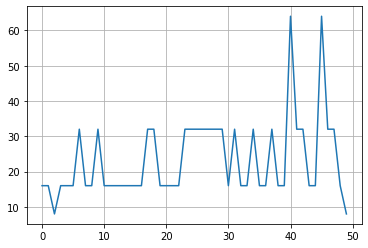

In [71]:
kpi_df.max_tile.plot()
plt.grid()

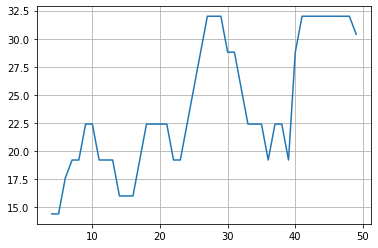

In [81]:
#smooth over 5 epochs

kpi_df.max_tile.rolling(5).mean().plot()
plt.grid()

## sum of tiles by epoch

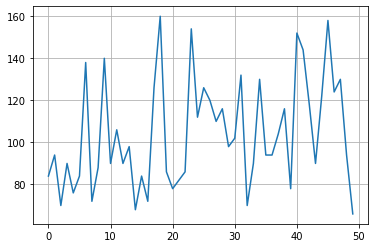

In [72]:
kpi_df.sum_of_tile.plot()
plt.grid()

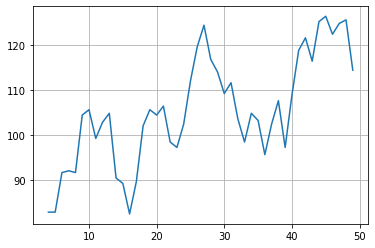

In [82]:
#smooth over 5 epochs

kpi_df.sum_of_tile.rolling(5).mean().plot()
plt.grid()

## total tries until game ends, by epoch

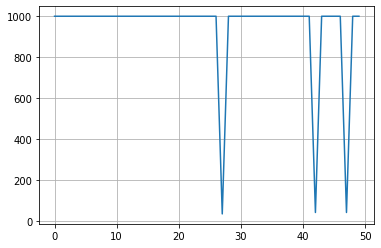

In [74]:
kpi_df.steps.plot()
plt.grid()